# **Module 3: AI tools**
## DAT410

### Group 29 
### David Laessker, 980511-5012, laessker@chalmers.se

### Oskar Palmgren, 010529-4714, oskarpal@chalmers.se



We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions.

___


## 1) Article summary and take-aways

The article talks about technical debt, specifically in machine learning. They argue that ML system has a special capacity to incur technical debt. It mentions different aspects of this. 

In the section (2 Complex Models Erode Boundaries) we particilarly thought that the examples of Correction Cascaces and Undeclared customers were interesting. 

In the section (3 Data Dependencies Cost More than Code Dependecies) it mentions how some unstable or underitilized data dependenencies can be detremental in the long term. 

In the section (4 Feedback Loops) it talks about how some aspects of a system may influence the functionality of others without the direct knowledge of the developers. We particularly thought that the example of how different recommendation systems on a website could influence eachother was interesting.

Section (5 ML-System Anti-Patterns) talks about the importance of abstraction and structure when writing ML code. How package structure and code visibility can be important, and gives examples of certain pitfalls that can happen when implemnented correctly or when the code is worked on by different people with different underlying knowledge of the previous implementations.

In section (6 Configuration Debt) the article gives examples of how the imporance of proper configuration of ML projects/implementations. It should be easy for a new user to make changes to the configuration and recognize the differences in configurations, while reducing the amounts of possible errors that can be made, while also easing the regonition of these potential errors.

The Section (7 Dealing with changes in the external world) mentions several ideas on how to keep a system ready for change in the external world, and how to test the system so that the developers are able to properly adapt the system to the changes.

(8 Other Areas of ML-related Debt) highlights some other important things like Rerproducability-, Procces Management, and Cultural Debt.

In the last conclusion chapter they discuss how to look at technical debt in ML systems and they mention that they hope the paper can help aid in engineers having the ability to create more maintainable and sustainable systems.

Our takaways were mainly the importance of considering many aspects on how the ML code/system is integreated with the data and the world around it. To always keep in mind that for code to be usable by future engineers, or the developers themselves in the future, it is important that things are clear, structured, and that the system dependencies are well thought out. Sometimes things can influence eachother without our knowledge, and that can be a detrement to the system.

___
## 2) Implementation

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Read in the data
beijing_data = pd.read_csv("Beijing_labeled.csv")
chengdu_data = pd.read_csv('Chengdu_labeled.csv')
guangzhou_data = pd.read_csv('Guangzhou_labeled.csv')
shanghai_data = pd.read_csv('Shanghai_labeled.csv')
shenyang_data = pd.read_csv('Shenyang_labeled.csv')

In [6]:
X_train = beijing_data.copy().drop('PM_HIGH', axis=1)
y_train = beijing_data.copy()['PM_HIGH'].astype(int)

X_val = shenyang_data.copy().drop('PM_HIGH', axis=1)
y_val = shenyang_data.copy()['PM_HIGH'].astype(int)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Use the same scaler to transform validation data


In [14]:
class Classifier:
    def __init__(self, n_clusters=2):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        self.cluster_labels = None

    def fit(self, X, y):
        # Fit the classifier
        self.kmeans.fit(X)
        self.cluster_labels = np.zeros(self.kmeans.n_clusters, dtype=int)
        for i in range(self.kmeans.n_clusters):
            """ 
            Assign labels to clusters based on majority vote

            - Segment the training data into clusters.

            - For each cluster, figure out which label (0 for low pollution, 1 for high pollution) 
            is most common among the data points in that cluster.

            -Assign this most common label to the cluster itself, effectively "labeling" 
            the cluster based on the predominant label of its members.
            """
            # Find the index of points in cluster i
            indexes = np.where(self.kmeans.labels_ == i)[0]
            # Assign the majority label to the cluster
            cluster_label = np.bincount(y[indexes]).argmax()
            self.cluster_labels[i] = cluster_label

    def predict(self, X):
        # Predict the labels
        cluster_indexes = self.kmeans.predict(X)
        return np.array([self.cluster_labels[i] for i in cluster_indexes])
    
    def score(self, X, y):
        # Score the classifier
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def f1_score(self, X, y):
        # F1 score
        predictions = self.predict(X)
        tp = np.sum((predictions == 1) & (y == 1))
        fp = np.sum((predictions == 1) & (y == 0))
        fn = np.sum((predictions == 0) & (y == 1))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        return 2 * precision * recall / (precision + recall)
    
    def conf_mat(self, X, y):
        
        matrix = confusion_matrix(self.predict(X), y)
        
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    
    

In [15]:
classifier = Classifier(n_clusters=48)  # Consider experimenting with the number of clusters
classifier.fit(X_train_scaled, y_train)
print("Training Accuracy: ", classifier.score(X_train_scaled, y_train), "F1 Score: ", classifier.f1_score(X_train_scaled, y_train))
print("Validation Accuracy: ", classifier.score(X_val_scaled, y_val), "F1 Score: ", classifier.f1_score(X_val_scaled, y_val))

c:\Users\P_Osk\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Accuracy:  0.7677450507001449 F1 Score:  0.5849870578084555
Validation Accuracy:  0.779126213592233 F1 Score:  0.47398843930635837


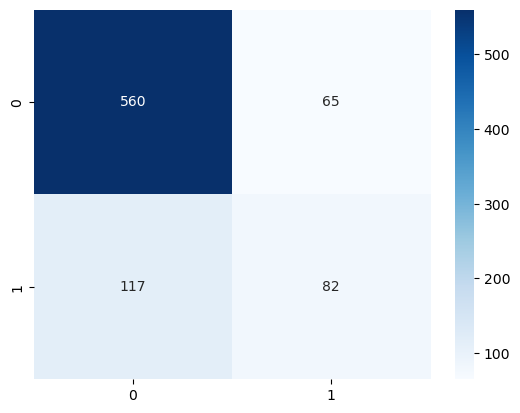

In [17]:
classifier.conf_mat(X_val_scaled, y_val)

In [18]:
# Find out which amount of clusters has the highest F1 score, plot the results
f1_scores = []
for n_clusters in range(2, 100):
    classifier = Classifier(n_clusters=n_clusters)
    classifier.fit(X_train_scaled, y_train)
    f1_scores.append(classifier.f1_score(X_val_scaled, y_val))

import matplotlib.pyplot as plt
plt.plot(range(2, 100), f1_scores)
plt.xlabel('Number of clusters')
plt.ylabel('F1 Score')
plt.show()

c:\Users\P_Osk\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\P_Osk\AppData\Local\Temp\ipykernel_21360\760446691.py:44: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
c:\Users\P_Osk\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\P_Osk\AppData\Local\Temp\ipykernel_21360\760446691.py:44: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
c:\Users\P_Osk\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10

In [108]:
# Score for the other cities
X_val = chengdu_data.drop('PM_HIGH', axis=1)
y_val = chengdu_data['PM_HIGH'].astype(int)
X_val_scaled = scaler.transform(X_val)
print("Chengdu Accuracy: ", classifier.score(X_val_scaled, y_val))

X_val = guangzhou_data.drop('PM_HIGH', axis=1)
y_val = guangzhou_data['PM_HIGH'].astype(int)
X_val_scaled = scaler.transform(X_val)
print("Guangzhou Accuracy: ", classifier.score(X_val_scaled, y_val))

X_val = shanghai_data.drop('PM_HIGH', axis=1)
y_val = shanghai_data['PM_HIGH'].astype(int)
X_val_scaled = scaler.transform(X_val)
print("Shanghai Accuracy: ", classifier.score(X_val_scaled, y_val))

Chengdu Accuracy:  0.7360360360360361
Guangzhou Accuracy:  0.8247041420118343
Shanghai Accuracy:  0.7083641746854182
